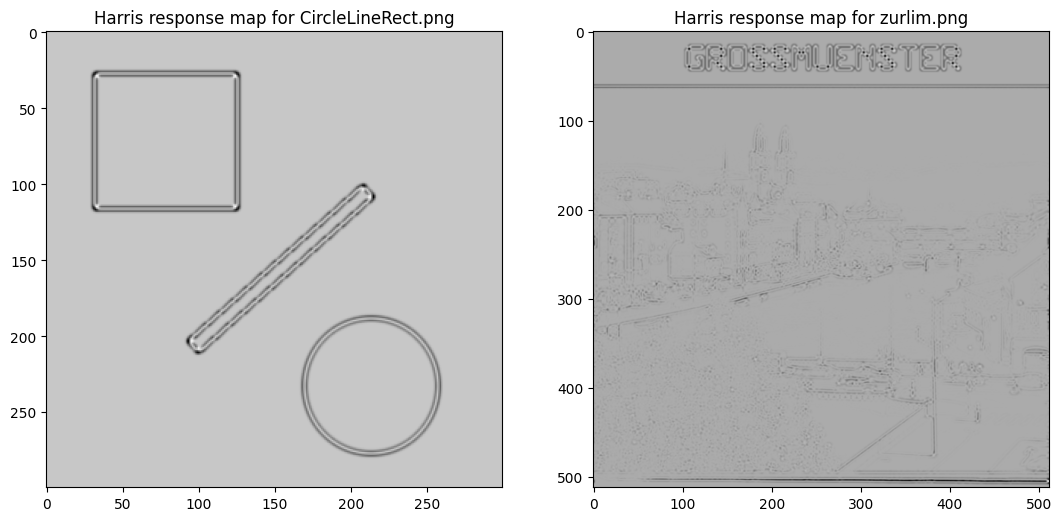

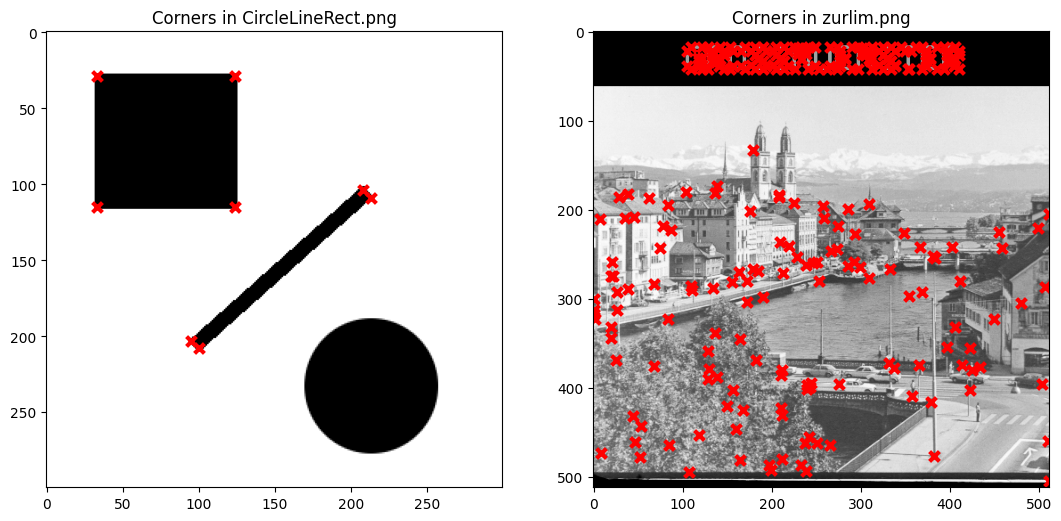

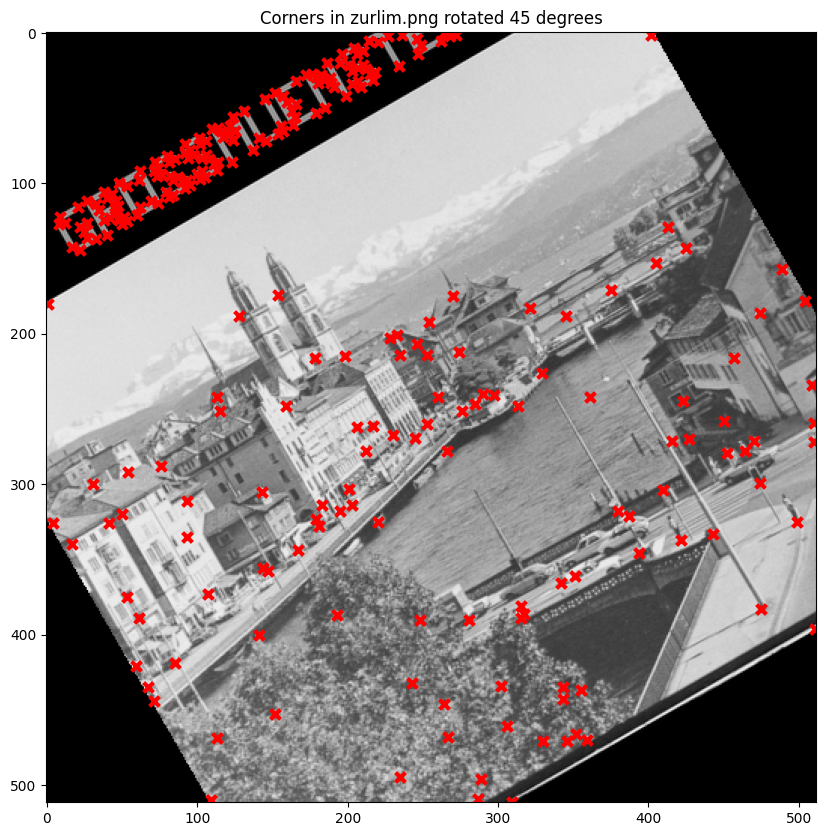

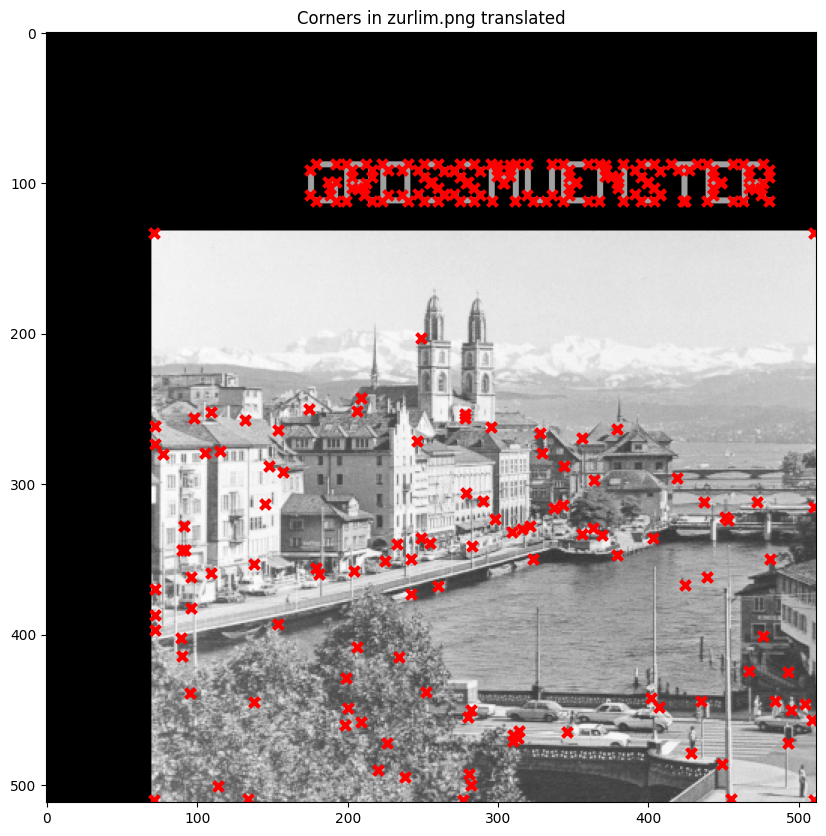

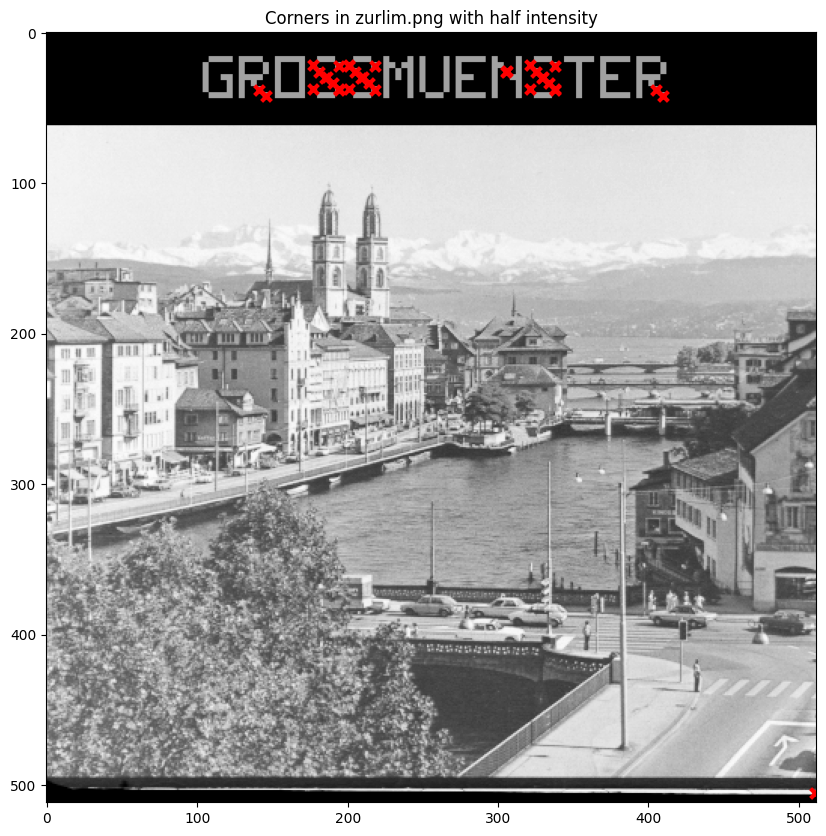

In [5]:

import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
from scipy.ndimage import convolve
from scipy.signal import convolve2d




def load_image(filename, as_gray=False, as_float=False):
    if as_gray:
        a = np.asarray(Image.open(filename).convert('L'))
    else:
        a = np.asarray(Image.open(filename))
    if as_float:
        return a.astype(np.float) / 255
    else:
        return a

def display_image(im, as_gray=False, title=None):
    plt.figure(figsize=(9,4))
    if as_gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    if title is not None:
        plt.title(title)

def display_vec(v, title=None):
    plt.figure(figsize=(9,4))
    plt.plot(v)
    if title is not None:
        plt.title(title)
        




I = load_image('CircleLineRect.png', as_gray=True, as_float=False)
I2 = load_image('zurlim.png', as_gray=True, as_float=False)

#step 1 smoothing of the image

kernel_size = 5
sigma = 1.0

kernel = np.fromfunction(
    lambda x, y: (1/ (2 * np.pi * sigma**2)) *
                  np.exp(-((x - (kernel_size - 1) / 2)**2 + (y - (kernel_size - 1) / 2)**2) / (2 * sigma**2)),
    (kernel_size, kernel_size)
)
kernel /= np.sum(kernel)
Gaussien_filter_6 = convolve2d(I, kernel, mode='same', boundary='wrap')


# defining Ix and Iy
vertical_sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
horizontal_sobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)



Ix = convolve2d(I, vertical_sobel, mode='same', boundary='wrap')
Iy = convolve2d(I, horizontal_sobel, mode='same', boundary='wrap')

# approximating the gradient Magnitude

gradient_magnitude = np.sqrt(np.square(Ix) + np.square(Iy))
gradient_magnitude *= 255.0 / gradient_magnitude.max()



#Define a function for getting the autocorrelation matrix at aa given pixel (i,j)

def get_autocorr_matrix(i, j, Ix2, Iy2, Ixy):

    #Acces the values of the partial derivatives at pixel (i,j)
    Ix2_ij = Ix2[i,j]
    Iy2_ij = Iy2[i,j]
    Ixy_ij = Ixy[i,j]

    A = np.array([[Ix2_ij, Ixy_ij], [Ixy_ij, Iy2_ij]])
    return A

# Implement the Harris response function at base pixel (i,j)

def get_harris_response(i, j, Ix2, Iy2, Ixy, k=0.2):
    A = get_autocorr_matrix(i, j, Ix2, Iy2, Ixy)
    det = np.linalg.det(A)
    trace = np.trace(A)
    R = det - k * trace**2
    return R

# Compute the Harris response for all pixel
def get_harris_response_map(Ix2, Iy2, Ixy):
    height, width = Ix2.shape
    R = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            R[i,j] = get_harris_response(i, j, Ix2, Iy2, Ixy)
    return R


#Define a funciton fro checking is a pixel is a local maximum in his neightborhood of 9 pixels on an image

def is_local_maximum(i, j, R, radius=1):
    height, width = R.shape
    for k in range(-radius, radius+1):
        for l in range(-radius, radius+1):
            if (i+k) >= 0 and (i+k) < height and (j+l) >= 0 and (j+l) < width:
                if R[i,j] < R[i+k,j+l]:
                    return False
    return True

##is_local_maximum TESTING

im_test = np.zeros((10,10))
im_test[3:7, 3:7] = 1


assert is_local_maximum(3, 3, im_test, radius=1) == True
assert is_local_maximum(3, 2, im_test, radius=2) == False



#Implement non maximum suppression using is_local_maximum and a threshold theta

def non_maximum_suppression(R, theta=100000):
    height, width = R.shape
    R_nms = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            if R[i,j] > theta and is_local_maximum(i, j, R):
                R_nms[i,j] = 1 #We set it to 1 to get rid of small values an, by doing this, we control the threshold on the nomaximum suppression method directly
    return R_nms








#FIRST IMAGE: CircleLineRect.png


#### STEP 1
I_x = convolve2d(I, vertical_sobel, mode='same', boundary='wrap')
I_y = convolve2d(I, horizontal_sobel, mode='same', boundary='wrap')

#### STEP 2
I_x2 = convolve2d(Ix, vertical_sobel, mode='same', boundary='wrap')
I_y2 = convolve2d(Iy, horizontal_sobel, mode='same', boundary='wrap')
I_xy = convolve2d(Ix, horizontal_sobel, mode='same', boundary='wrap')


#### STEP 3
#Smooth version of the partial derivatives
sigma = 1
Ix2_smooth = ndimage.gaussian_filter(I_x2, sigma)
Iy2_smooth = ndimage.gaussian_filter(I_y2, sigma)
Ixy_smooth = ndimage.gaussian_filter(I_xy, sigma)


### STEP 4
#Compute the Harris response map
R_1 = get_harris_response_map(Ix2_smooth, Iy2_smooth, Ixy_smooth)

### STEP 5
R_1_nms = non_maximum_suppression(R_1)




#SECOND IMAGE: zurlim.png

#### STEP 1
I2_x = convolve2d(I2, vertical_sobel, mode='same', boundary='wrap')
I2_y = convolve2d(I2, horizontal_sobel, mode='same', boundary='wrap')

#### STEP 2
I2_x2 = convolve2d(I2_x, vertical_sobel, mode='same', boundary='wrap')
I2_y2 = convolve2d(I2_y, horizontal_sobel, mode='same', boundary='wrap')
I2_xy = convolve2d(I2_x, horizontal_sobel, mode='same', boundary='wrap')

#### Step 3
#Smooth version of the partial derivatives
sigma = 1
I2x2_smooth = ndimage.gaussian_filter(I2_x2, sigma)
I2y2_smooth = ndimage.gaussian_filter(I2_y2, sigma)
I2xy_smooth = ndimage.gaussian_filter(I2_xy, sigma)

### STEP 4
#Compute the Harris response map
R_2 = get_harris_response_map(I2x2_smooth, I2y2_smooth, I2xy_smooth)

### STEP 5
R_2_nms = non_maximum_suppression(R_2)
    



plt.figure(figsize=(20, 10))
plt.subplot(131), plt.imshow(R_1, cmap='gray'), plt.title('Harris response map for CircleLineRect.png')
plt.subplot(132), plt.imshow(R_2, cmap='gray'), plt.title('Harris response map for zurlim.png')
plt.show()


plt.figure(figsize=(20, 10))
plt.subplot(131), plt.imshow(I, cmap='gray'),plt.scatter(np.nonzero(R_1_nms)[1], np.nonzero(R_1_nms)[0], s=50, c='r', marker='x', linewidths=3), plt.title('Corners in CircleLineRect.png')
plt.subplot(132), plt.imshow(I2, cmap='gray'),plt.scatter(np.nonzero(R_2_nms)[1], np.nonzero(R_2_nms)[0], s=50, c='r', marker='x', linewidths=3), plt.title('Corners in zurlim.png')
plt.show()

#############################################################################################################

### EXPERIMENTS WITH IMAGE TRANSFORMATIONS

### 1. Rotation


I2_rotated = ndimage.rotate(I2, 30, reshape=False)


#### STEP 1
I2_rotated_x = convolve2d(I2_rotated, vertical_sobel, mode='same', boundary='wrap')
I2_rotated_y = convolve2d(I2_rotated, horizontal_sobel, mode='same', boundary='wrap')

#### STEP 2
I2_rotated_x2 = convolve2d(I2_rotated_x, vertical_sobel, mode='same', boundary='wrap')
I2_rotated_y2 = convolve2d(I2_rotated_y, horizontal_sobel, mode='same', boundary='wrap')
I2_rotated_xy = convolve2d(I2_rotated_x, horizontal_sobel, mode='same', boundary='wrap')


#### STEP 3
#Smooth version of the partial derivatives
sigma = 1
I2_rotated_x2_smooth = ndimage.gaussian_filter(I2_rotated_x2, sigma)
I2_rotated_y2_smooth = ndimage.gaussian_filter(I2_rotated_y2, sigma)
I2_rotated_xy_smooth = ndimage.gaussian_filter(I2_rotated_xy, sigma)

### STEP 4
#Compute the Harris response map
R_2_rotated = get_harris_response_map(I2_rotated_x2_smooth, I2_rotated_y2_smooth, I2_rotated_xy_smooth)

### STEP 5
R_2_rotated_nms = non_maximum_suppression(R_2_rotated)

## UCOMMENT TO SEE THE RESULTS OF THE ROTATION
plt.figure(figsize=(20, 10))
plt.imshow(I2_rotated, cmap='gray'),plt.scatter(np.nonzero(R_2_rotated_nms)[1], np.nonzero(R_2_rotated_nms)[0], s=50, c='r', marker='x', linewidths=3), plt.title('Corners in zurlim.png rotated 45 degrees')
plt.show()


#############################################################################################################


### 2. Translation

#Rotate the I2 image 45 degrees

I2_translated = ndimage.shift(I2, (70, 70))



#### STEP 1
I2_translated_x = convolve2d(I2_translated, vertical_sobel, mode='same', boundary='wrap')
I2_translated_y = convolve2d(I2_translated, horizontal_sobel, mode='same', boundary='wrap')

#### STEP 2
I2_translated_x2 = convolve2d(I2_translated_x, vertical_sobel, mode='same', boundary='wrap')
I2_translated_y2 = convolve2d(I2_translated_y, horizontal_sobel, mode='same', boundary='wrap')
I2_translated_xy = convolve2d(I2_translated_x, horizontal_sobel, mode='same', boundary='wrap')


#### STEP 3
#Smooth version of the partial derivatives
sigma = 1
I2_translated_x2_smooth = ndimage.gaussian_filter(I2_translated_x2, sigma)
I2_translated_y2_smooth = ndimage.gaussian_filter(I2_translated_y2, sigma)
I2_translated_xy_smooth = ndimage.gaussian_filter(I2_translated_xy, sigma)

### STEP 4
#Compute the Harris response map
R_2_translated = get_harris_response_map(I2_translated_x2_smooth, I2_translated_y2_smooth, I2_translated_xy_smooth)

### STEP 5
R_2_translated_nms = non_maximum_suppression(R_2_translated)

## UCOMMENT TO SEE THE RESULTS OF THE TRANSLATION
plt.figure(figsize=(20, 10))
plt.imshow(I2_translated, cmap='gray'),plt.scatter(np.nonzero(R_2_translated_nms)[1], np.nonzero(R_2_translated_nms)[0], s=50, c='r', marker='x', linewidths=3), plt.title('Corners in zurlim.png translated')
plt.show()


#############################################################################################################


### 3. Scaling

#Change the intensity of the I2 image

I2_intensity = I2 * 0.5

#### STEP 1
I2_intensity_x = convolve2d(I2_intensity, vertical_sobel, mode='same', boundary='wrap')
I2_intensity_y = convolve2d(I2_intensity, horizontal_sobel, mode='same', boundary='wrap')

#### STEP 2
I2_intensity_x2 = convolve2d(I2_intensity_x, vertical_sobel, mode='same', boundary='wrap')
I2_intensity_y2 = convolve2d(I2_intensity_y, horizontal_sobel, mode='same', boundary='wrap')
I2_intensity_xy = convolve2d(I2_intensity_x, horizontal_sobel, mode='same', boundary='wrap')


#### STEP 3
#Smooth version of the partial derivatives
sigma = 1
I2_intensity_x2_smooth = ndimage.gaussian_filter(I2_intensity_x2, sigma)
I2_intensity_y2_smooth = ndimage.gaussian_filter(I2_intensity_y2, sigma)
I2_intensity_xy_smooth = ndimage.gaussian_filter(I2_intensity_xy, sigma)

### STEP 4
#Compute the Harris response map

R_2_intensity = get_harris_response_map(I2_intensity_x2_smooth, I2_intensity_y2_smooth, I2_intensity_xy_smooth)

### STEP 5
R_2_intensity_nms = non_maximum_suppression(R_2_intensity)


## UCOMMENT TO SEE THE RESULTS OF THE INTENSITY CHANGE
plt.figure(figsize=(20, 10))
plt.imshow(I2_intensity, cmap='gray'),plt.scatter(np.nonzero(R_2_intensity_nms)[1], np.nonzero(R_2_intensity_nms)[0], s=50, c='r', marker='x', linewidths=3), plt.title('Corners in zurlim.png with half intensity')
plt.show()
